In [1]:
import sys
import os

import ccxt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()))))
from src.analysis_logic import AnalysisLogic, FitMethods

sns.set_style("darkgrid")

In [2]:
save_folderpath = os.path.join("..", "images", "9_BitcoinSinusoids")

## Get data


### Get historical data


In [3]:
filepath = os.path.join(
    "..", "data", "bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df = pd.read_csv(filepath)
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit='s')
df = df.set_index("Timestamp", drop=True)
df = df[df.index > pd.to_datetime('2012-01-01')]
df = df.dropna().reset_index().set_index("Timestamp", drop=True)

In [4]:
# business month start frequency
df = df.resample("MS").apply({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
})

In [5]:
df.head()

,Open,High,Low,Close
Timestamp,,,,
2012-01-01,4.58,7.38,3.80,5.30
2012-02-01,5.53,6.50,4.14,4.99
2012-03-01,4.99,5.44,4.54,4.90
2012-04-01,4.89,5.43,4.69,5.00
2012-05-01,4.94,5.17,4.86,5.17


### Get latest data


In [6]:
binance = ccxt.binance()
data = binance.fetch_ohlcv(
    'BTC/USDT', '1M', since=int((df.index[-1] + pd.Timedelta(days=31)).timestamp() * 1000))

df2 = pd.DataFrame(
    data, columns=["Timestamp", "Open", "High", "Low", "Close", "Volume"])

df2["Timestamp"] = pd.to_datetime(df2["Timestamp"], unit='ms')
df2 = df2.set_index("Timestamp", drop=True)
df2 = df2.drop(["Volume"], axis=1)

In [7]:
df = pd.concat([df, df2])

Text(0.5, 0, 'Time')

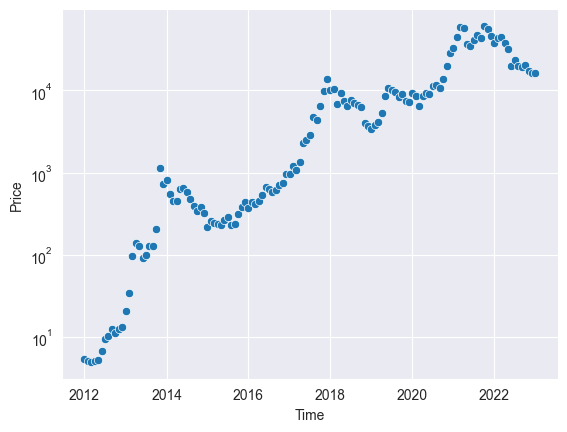

In [8]:
ax = sns.scatterplot(x=df.index, y="Close", data=df)
ax.set_yscale("log")

ax.set_ylabel("Price")
ax.set_xlabel("Time")

## Plot log data with different fits


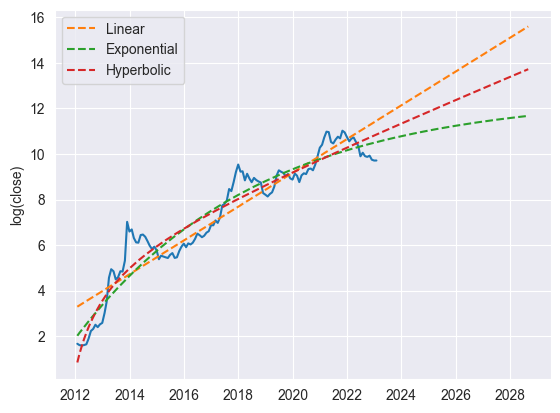

In [9]:
analysis = AnalysisLogic()

x = df.index.factorize()[0]
y = np.log(df["Close"])

x_dates = pd.date_range(start=df.index[0], periods=len(x), freq="m")

fig, ax = plt.subplots()
sns.lineplot(x=x_dates, y=y, ax=ax)

fit_x_lin, fit_y_lin, result_lin = analysis.perform_fit(
    x=x, y=y, fit_function=FitMethods.linear)
# sns.lineplot(x=fit_x_lin, y=fit_y_lin, ax=ax, label="Linear fit")

fit_x_exp, fit_y_exp, result_exp = analysis.perform_fit(
    x=x, y=y, fit_function=FitMethods.decayexponential)
# sns.lineplot(x=fit_x_exp, y=fit_y_exp, ax=ax, label="Exponential fit")

fit_x_hyp, fit_y_hyp, result_hyp = analysis.perform_fit(
    x=x, y=y, fit_function=FitMethods.hyperbolicsaturation)
# sns.lineplot(x=fit_x_hyp, y=fit_y_hyp, ax=ax, label="Hyperbolic fit")

# Extrapolations
x_extra = np.arange(0, 200)
x_dates_extra = pd.date_range(
    start=df.index[0], periods=len(x_extra), freq="m")

sns.lineplot(x=x_dates_extra, y=result_lin.eval(
    x=x_extra), ax=ax, linestyle="--", label="Linear")
sns.lineplot(x=x_dates_extra, y=result_exp.eval(x=x_extra),
             ax=ax, linestyle="--", label="Exponential")
sns.lineplot(x=x_dates_extra, y=result_hyp.eval(x=x_extra),
             ax=ax, linestyle="--", label="Hyperbolic")

ax.set_ylabel("log(close)")

fig.savefig(os.path.join(save_folderpath, "log_plot_fits.jpg"), dpi=300, bbox_inches="tight")

## Extrapolate sine fits to different log models


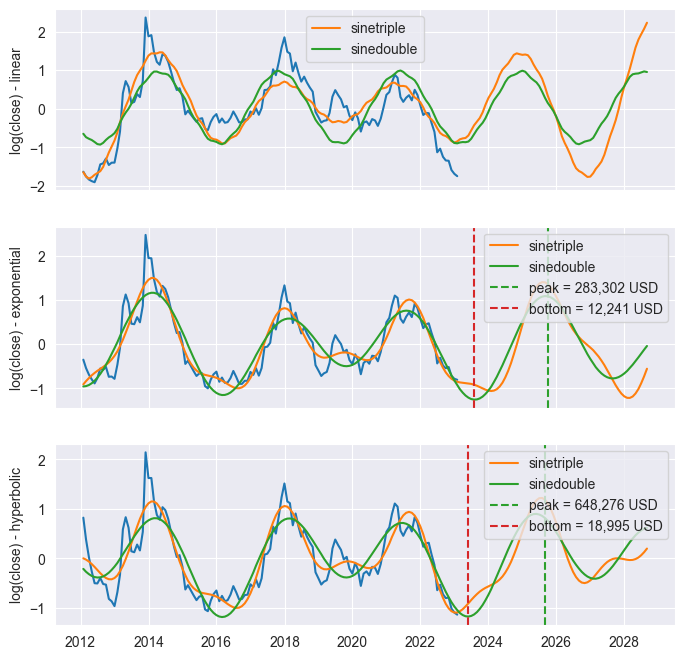

In [10]:
analysis = AnalysisLogic()

fig, (ax, ax1, ax2) = plt.subplots(nrows=3, sharex="col", figsize=(8, 8))

x_dates = pd.date_range(start=df.index[0], periods=len(x), freq="m")
x_dates_extrapolated = pd.date_range(start=df.index[0], periods=200, freq="m")

# Linear
y_shifted_lin = y - result_lin.eval(x=x)
sns.lineplot(x=x_dates, y=y_shifted_lin, ax=ax)

_, _, result_st_lin = analysis.perform_fit(
    x=x, y=y_shifted_lin, fit_function=FitMethods.sinetriple)
sns.lineplot(x=x_dates_extrapolated, y=result_st_lin.eval(
    x=np.arange(0, 200)), ax=ax, label="sinetriple")

_, _, result_sd_lin = analysis.perform_fit(
    x=x, y=y_shifted_lin, fit_function=FitMethods.sinedouble)
sns.lineplot(x=x_dates_extrapolated, y=result_sd_lin.eval(
    x=np.arange(0, 200)), ax=ax, label="sinedouble")

# Exponential
y_shifted_exp = y - result_exp.eval(x=x)
sns.lineplot(x=x_dates, y=y_shifted_exp, ax=ax1)

_, _, result_st_exp = analysis.perform_fit(
    x=x, y=y_shifted_exp, fit_function=FitMethods.sinetriple)
sns.lineplot(x=x_dates_extrapolated, y=result_st_exp.eval(
    x=np.arange(0, 200)), ax=ax1, label="sinetriple")

_, _, result_sd_exp = analysis.perform_fit(
    x=x, y=y_shifted_exp, fit_function=FitMethods.sinedouble)
sns.lineplot(x=x_dates_extrapolated, y=result_sd_exp.eval(
    x=np.arange(0, 200)), ax=ax1, label="sinedouble")

# Hyperbolic
y_shifted_hyp = y - result_hyp.eval(x=x)
sns.lineplot(x=x_dates, y=y_shifted_hyp, ax=ax2)

_, _, result_st_hyp = analysis.perform_fit(
    x=x, y=y_shifted_hyp, fit_function=FitMethods.sinetriple)
sns.lineplot(x=x_dates_extrapolated, y=result_st_hyp.eval(
    x=np.arange(0, 200)), ax=ax2, label="sinetriple")

_, _, result_sd_hyp = analysis.perform_fit(
    x=x, y=y_shifted_hyp, fit_function=FitMethods.sinedouble)
sns.lineplot(x=x_dates_extrapolated, y=result_sd_hyp.eval(
    x=np.arange(0, 200)), ax=ax2, label="sinedouble")

# Exponential
peak_st_exp = 164
price_peak_exp = int(np.exp(result_exp.eval(
    x=peak_st_exp) + result_st_exp.eval(x=peak_st_exp)))
bottom_sd_exp = 138
price_bottom_exp = int(np.exp(result_exp.eval(
    x=bottom_sd_exp) + result_sd_exp.eval(x=bottom_sd_exp)))

ax1.axvline(x_dates_extrapolated[peak_st_exp], color="C2",
            label=f"peak = {price_peak_exp:,} USD", linestyle="--")
ax1.axvline(x_dates_extrapolated[bottom_sd_exp], color="C3",
            label=f"bottom = {price_bottom_exp:,} USD", linestyle="--")

# Hyperbolic
peak_st_hyp = 163
price_peak_hyp = int(np.exp(result_hyp.eval(
    x=peak_st_hyp) + result_st_hyp.eval(x=peak_st_hyp)))
bottom_sd_hyp = 136
price_bottom_hyp = int(np.exp(result_hyp.eval(
    x=bottom_sd_hyp) + result_sd_hyp.eval(x=bottom_sd_hyp)))

ax2.axvline(x_dates_extrapolated[peak_st_hyp], color="C2",
            label=f"peak = {price_peak_hyp:,} USD", linestyle="--")
ax2.axvline(x_dates_extrapolated[bottom_sd_hyp], color="C3",
            label=f"bottom = {price_bottom_hyp:,} USD", linestyle="--")


ax.set_ylabel("log(close) - linear")
ax1.set_ylabel("log(close) - exponential")
ax2.set_ylabel("log(close) - hyperbolic")

ax.legend()
ax1.legend()
ax2.legend()

fig.savefig(os.path.join(save_folderpath, "log_plot_sine_fits.jpg"), dpi=300, bbox_inches="tight")

## Deeper look into exponential decay model, mark out cycles


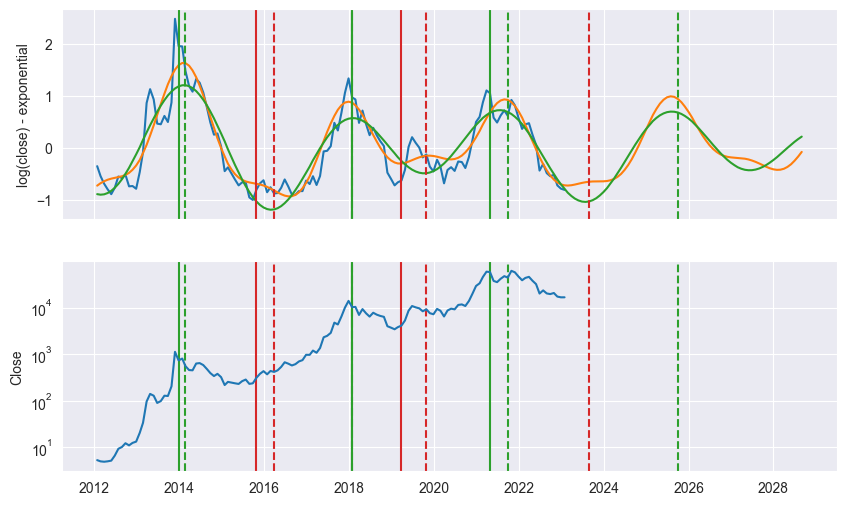

In [11]:
fig, (ax, ax1) = plt.subplots(nrows=2, figsize=(10, 6), sharex="col")

x_dates = pd.date_range(start=df.index[0], periods=len(x), freq="m")
x_dates_exptrapolated = pd.date_range(start=df.index[0], periods=200, freq="m")

# Exponential
y_shifted_exp = y - result_exp.eval(x=x)
sns.lineplot(x=x_dates, y=y_shifted_exp, ax=ax)

_, _, result_st_exp = analysis.perform_fit(
    x=x, y=y_shifted_exp, fit_function=FitMethods.sinetriplewithexpdecay)
sns.lineplot(x=x_dates_exptrapolated,
             y=result_st_exp.eval(x=np.arange(0, 200)), ax=ax)

_, _, result_sd_exp = analysis.perform_fit(
    x=x, y=y_shifted_exp, fit_function=FitMethods.sinedoublewithexpdecay)
sns.lineplot(x=x_dates_exptrapolated,
             y=result_sd_exp.eval(x=np.arange(0, 200)), ax=ax)


# Model peaks and bottoms

# Cycle 1
peak_st_exp_c1 = 25
price_peak_exp_c1 = int(np.exp(result_exp.eval(
    x=peak_st_exp_c1) + result_st_exp.eval(x=peak_st_exp_c1)))
bottom_sd_exp_c1 = 50
price_bottom_exp_c1 = int(np.exp(result_exp.eval(
    x=bottom_sd_exp_c1) + result_sd_exp.eval(x=bottom_sd_exp_c1)))

ax.axvline(x_dates_exptrapolated[peak_st_exp_c1], color="C2", linestyle="--")
ax1.axvline(x_dates_exptrapolated[peak_st_exp_c1], color="C2", linestyle="--")

ax.axvline(x_dates_exptrapolated[bottom_sd_exp_c1], color="C3", linestyle="--")
ax1.axvline(
    x_dates_exptrapolated[bottom_sd_exp_c1], color="C3", linestyle="--")

# Cycle 2
peak_st_exp_c2 = 72
price_peak_exp_c2 = int(np.exp(result_exp.eval(
    x=peak_st_exp_c2) + result_st_exp.eval(x=peak_st_exp_c2)))
bottom_sd_exp_c2 = 93
price_bottom_exp_c2 = int(np.exp(result_exp.eval(
    x=bottom_sd_exp_c2) + result_sd_exp.eval(x=bottom_sd_exp_c2)))

ax.axvline(x_dates_exptrapolated[peak_st_exp_c2], color="C2", linestyle="--")
ax1.axvline(x_dates_exptrapolated[peak_st_exp_c2], color="C2", linestyle="--")

ax.axvline(x_dates_exptrapolated[bottom_sd_exp_c2], color="C3", linestyle="--")
ax1.axvline(
    x_dates_exptrapolated[bottom_sd_exp_c2], color="C3", linestyle="--")

# Cycle 3
peak_st_exp_c3 = 116
price_peak_exp_c3 = int(np.exp(result_exp.eval(
    x=peak_st_exp_c3) + result_st_exp.eval(x=peak_st_exp_c3)))
bottom_sd_exp_c3 = 139
price_bottom_exp_c3 = int(np.exp(result_exp.eval(
    x=bottom_sd_exp_c3) + result_sd_exp.eval(x=bottom_sd_exp_c3)))

ax.axvline(x_dates_exptrapolated[peak_st_exp_c3], color="C2", linestyle="--")
ax1.axvline(x_dates_exptrapolated[peak_st_exp_c3], color="C2", linestyle="--")

ax.axvline(x_dates_exptrapolated[bottom_sd_exp_c3], color="C3", linestyle="--")
ax1.axvline(
    x_dates_exptrapolated[bottom_sd_exp_c3], color="C3", linestyle="--")

# Cycle 4
peak_st_exp_c4 = 164
price_peak_exp_c4 = int(np.exp(result_exp.eval(
    x=peak_st_exp_c4) + result_st_exp.eval(x=peak_st_exp_c4)))

ax.axvline(x_dates_exptrapolated[peak_st_exp_c4], color="C2", linestyle="--")
ax1.axvline(x_dates_exptrapolated[peak_st_exp_c4], color="C2", linestyle="--")

# Actual peaks and bottoms

# Cycle 1
peak_st_c1 = 23
bottom_sd_c1 = 45

ax.axvline(x_dates[peak_st_c1], color="C2", linestyle="-")
ax1.axvline(x_dates[peak_st_c1], color="C2", linestyle="-")

ax.axvline(x_dates[bottom_sd_c1], color="C3", linestyle="-")
ax1.axvline(x_dates[bottom_sd_c1], color="C3", linestyle="-")

# Cycle 2
peak_st_c2 = 72
bottom_sd_c2 = 86

ax.axvline(x_dates[peak_st_c2], color="C2", linestyle="-")
ax1.axvline(x_dates[peak_st_c2], color="C2", linestyle="-")

ax.axvline(x_dates[bottom_sd_c2], color="C3", linestyle="-")
ax1.axvline(x_dates[bottom_sd_c2], color="C3", linestyle="-")

# Cycle 3
peak_st_c3 = 111
ax.axvline(x_dates[peak_st_c3], color="C2", linestyle="-")
ax1.axvline(x_dates[peak_st_c3], color="C2", linestyle="-")

# ax.legend()

ax.set_ylabel("log(close) - exponential")

sns.lineplot(x=x_dates, y=df["Close"], ax=ax1)
ax1.set_yscale("log")

### Errors in price


In [12]:
peak_errors_pct = np.array([
    (price_peak_exp_c1 - df["Close"][peak_st_c1]) /
    df["Close"][peak_st_c1] * 100,
    (price_peak_exp_c2 - df["Close"][peak_st_c2]) /
    df["Close"][peak_st_c2] * 100,
    (price_peak_exp_c3 - df["Close"][peak_st_c3]) /
    df["Close"][peak_st_c3] * 100,
])

print(peak_errors_pct)

bottom_errors_pct = np.array([
    (price_bottom_exp_c1 - df["Close"][bottom_sd_c1]
     ) / df["Close"][bottom_sd_c1] * 100,
    (price_bottom_exp_c2 - df["Close"][bottom_sd_c2]
     ) / df["Close"][bottom_sd_c2] * 100,
])

print(bottom_errors_pct)

peak_price_error_pct = np.mean(peak_errors_pct)
bottom_price_error_pct = np.mean(bottom_errors_pct)

print(peak_price_error_pct, bottom_price_error_pct)

bottom_pred_upper = price_bottom_exp_c3 + \
    bottom_price_error_pct / 100 * price_bottom_exp_c3
bottom_pred_lower = price_bottom_exp_c3 - \
    bottom_price_error_pct / 100 * price_bottom_exp_c3

peak_pred_upper = price_peak_exp_c4 + \
    peak_price_error_pct / 100 * price_peak_exp_c4
peak_pred_lower = price_peak_exp_c4 - \
    peak_price_error_pct / 100 * price_peak_exp_c4

[-12.43169399  -9.42950044   3.05529475]
[-1.66999807 55.83191735]
-6.268633228852143 27.08095963986252


### Error in time


In [13]:
peak_diff_in_months = [
    peak_st_c1 - peak_st_exp_c1,
    peak_st_c2 - peak_st_exp_c2,
    peak_st_c3 - peak_st_exp_c3,
]

print(peak_diff_in_months)

bottom_diff_in_months = [
    bottom_sd_c1 - bottom_sd_exp_c1,
    bottom_sd_c2 - bottom_sd_exp_c2,
]

print(bottom_diff_in_months)

peak_months_error = int(np.mean(peak_diff_in_months))
bottom_months_error = int(np.mean(bottom_diff_in_months))


print(peak_months_error, bottom_months_error)

[-2, 0, -5]
[-5, -7]
-2 -6


### With price and time errors


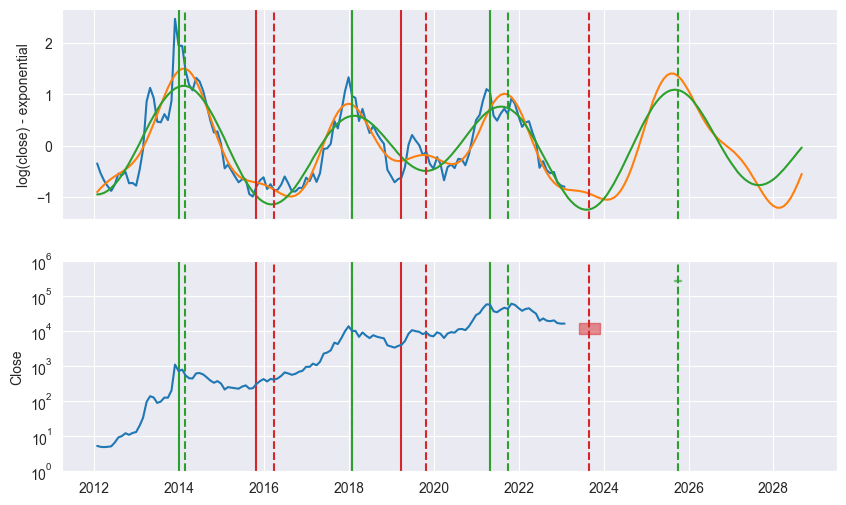

In [14]:
fig, (ax, ax1) = plt.subplots(nrows=2, figsize=(10, 6), sharex="col")

x_dates = pd.date_range(start=df.index[0], periods=len(x), freq="m")
x_dates_extrapolated = pd.date_range(start=df.index[0], periods=200, freq="m")

# Exponential
y_shifted_exp = y - result_exp.eval(x=x)
sns.lineplot(x=x_dates, y=y_shifted_exp, ax=ax)

_, _, result_st_exp = analysis.perform_fit(
    x=x, y=y_shifted_exp, fit_function=FitMethods.sinetriple)
sns.lineplot(x=x_dates_extrapolated,
             y=result_st_exp.eval(x=np.arange(0, 200)), ax=ax)

_, _, result_sd_exp = analysis.perform_fit(
    x=x, y=y_shifted_exp, fit_function=FitMethods.sinedouble)
sns.lineplot(x=x_dates_extrapolated,
             y=result_sd_exp.eval(x=np.arange(0, 200)), ax=ax)


# Model peaks and bottoms

# Cycle 1
peak_st_exp_c1 = 25
price_peak_exp_c1 = int(np.exp(result_exp.eval(
    x=peak_st_exp_c1) + result_st_exp.eval(x=peak_st_exp_c1)))
bottom_sd_exp_c1 = 50
price_bottom_exp_c1 = int(np.exp(result_exp.eval(
    x=bottom_sd_exp_c1) + result_sd_exp.eval(x=bottom_sd_exp_c1)))

ax.axvline(x_dates_extrapolated[peak_st_exp_c1], color="C2", linestyle="--")
ax1.axvline(x_dates_extrapolated[peak_st_exp_c1], color="C2", linestyle="--")

ax.axvline(x_dates_extrapolated[bottom_sd_exp_c1], color="C3", linestyle="--")
ax1.axvline(x_dates_extrapolated[bottom_sd_exp_c1], color="C3", linestyle="--")

# Cycle 2
peak_st_exp_c2 = 72
price_peak_exp_c2 = int(np.exp(result_exp.eval(
    x=peak_st_exp_c2) + result_st_exp.eval(x=peak_st_exp_c2)))
bottom_sd_exp_c2 = 93
price_bottom_exp_c2 = int(np.exp(result_exp.eval(
    x=bottom_sd_exp_c2) + result_sd_exp.eval(x=bottom_sd_exp_c2)))

ax.axvline(x_dates_extrapolated[peak_st_exp_c2], color="C2", linestyle="--")
ax1.axvline(x_dates_extrapolated[peak_st_exp_c2], color="C2", linestyle="--")

ax.axvline(x_dates_extrapolated[bottom_sd_exp_c2], color="C3", linestyle="--")
ax1.axvline(x_dates_extrapolated[bottom_sd_exp_c2], color="C3", linestyle="--")

# Cycle 3
peak_st_exp_c3 = 116
price_peak_exp_c3 = int(np.exp(result_exp.eval(
    x=peak_st_exp_c3) + result_st_exp.eval(x=peak_st_exp_c3)))
bottom_sd_exp_c3 = 139
price_bottom_exp_c3 = int(np.exp(result_exp.eval(
    x=bottom_sd_exp_c3) + result_sd_exp.eval(x=bottom_sd_exp_c3)))

ax.axvline(x_dates_extrapolated[peak_st_exp_c3], color="C2", linestyle="--")
ax1.axvline(x_dates_extrapolated[peak_st_exp_c3], color="C2", linestyle="--")

ax.axvline(x_dates_extrapolated[bottom_sd_exp_c3], color="C3", linestyle="--")
ax1.axvline(x_dates_extrapolated[bottom_sd_exp_c3], color="C3", linestyle="--")

# Cycle 4
peak_st_exp_c4 = 164
price_peak_exp_c4 = int(np.exp(result_exp.eval(
    x=peak_st_exp_c4) + result_st_exp.eval(x=peak_st_exp_c4)))

ax.axvline(x_dates_extrapolated[peak_st_exp_c4], color="C2", linestyle="--")
ax1.axvline(x_dates_extrapolated[peak_st_exp_c4], color="C2", linestyle="--")

# Actual peaks and bottoms

# Cycle 1
peak_st_c1 = 23
bottom_sd_c1 = 45

ax.axvline(x_dates[peak_st_c1], color="C2", linestyle="-")
ax1.axvline(x_dates[peak_st_c1], color="C2", linestyle="-")

ax.axvline(x_dates[bottom_sd_c1], color="C3", linestyle="-")
ax1.axvline(x_dates[bottom_sd_c1], color="C3", linestyle="-")

# Cycle 2
peak_st_c2 = 72
bottom_sd_c2 = 86

ax.axvline(x_dates[peak_st_c2], color="C2", linestyle="-")
ax1.axvline(x_dates[peak_st_c2], color="C2", linestyle="-")

ax.axvline(x_dates[bottom_sd_c2], color="C3", linestyle="-")
ax1.axvline(x_dates[bottom_sd_c2], color="C3", linestyle="-")

# Cycle 3
peak_st_c3 = 111
ax.axvline(x_dates[peak_st_c3], color="C2", linestyle="-")
ax1.axvline(x_dates[peak_st_c3], color="C2", linestyle="-")

# ax.legend()

ax.set_ylabel("log(close) - exponential")

sns.lineplot(x=x_dates, y=df["Close"], ax=ax1)
ax1.set_yscale("log")

bottom_error_width = mdates.date2num(x_dates_extrapolated[bottom_sd_exp_c3 + abs(
    bottom_months_error)]) - mdates.date2num(x_dates_extrapolated[bottom_sd_exp_c3])
bottom_error_height = abs(bottom_pred_upper - bottom_pred_lower)
bottom_x = (
    mdates.date2num(x_dates_extrapolated[bottom_sd_exp_c3]) -
    (mdates.date2num(x_dates_extrapolated[bottom_sd_exp_c3 + abs(
        bottom_months_error)]) - mdates.date2num(x_dates_extrapolated[bottom_sd_exp_c3])) / 2
)
bottom_y = price_bottom_exp_c3 - bottom_error_height / 2

ax1.add_patch(
    Rectangle(
        xy=(bottom_x, bottom_y),
        width=bottom_error_width,
        height=bottom_error_height,
        color="C3",
        alpha=0.5
    )
)

peak_error_width = mdates.date2num(x_dates_extrapolated[peak_st_exp_c4 + abs(
    peak_months_error)]) - mdates.date2num(x_dates_extrapolated[peak_st_exp_c4])
peak_error_height = abs(peak_pred_upper - peak_pred_lower)
peak_x = (
    mdates.date2num(x_dates_extrapolated[peak_st_exp_c4]) -
    (mdates.date2num(x_dates_extrapolated[peak_st_exp_c4 + abs(
        peak_months_error)]) - mdates.date2num(x_dates_extrapolated[peak_st_exp_c4])) / 2
)
peak_y = price_peak_exp_c4 - peak_error_height / 2

ax1.add_patch(
    Rectangle(
        xy=(peak_x, peak_y),
        width=peak_error_width,
        height=peak_error_height,
        color="C2",
        alpha=0.5
    )
)

ax1.set_ylim([1, 1e6])

fig.savefig(os.path.join(save_folderpath, "btc_sinusoid_predictions.jpg"), dpi=300, bbox_inches="tight")

In [15]:
f"Bottom ranges from {mdates.num2date(bottom_x)} to {mdates.num2date(bottom_x + bottom_error_width)}, \
with prices ranging between {int(bottom_y):,} USD and {int(bottom_y + bottom_error_height):,} USD."

'Bottom ranges from 2023-06-01 00:00:00+00:00 to 2023-11-30 00:00:00+00:00, with prices ranging between 8,324 USD and 16,853 USD.'

In [16]:
f"Peak ranges from {mdates.num2date(peak_x)} to {mdates.num2date(peak_x + peak_error_width)}, \
with prices ranging between {int(peak_y):,} USD and {int(peak_y + peak_error_height):,} USD."

'Peak ranges from 2025-08-30 12:00:00+00:00 to 2025-10-30 12:00:00+00:00, with prices ranging between 271,652 USD and 294,951 USD.'